In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import gc
from matplotlib import pyplot
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
import xgboost as xgb
from xgboost import plot_importance, plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Dense, Reshape, Dropout, LSTM, RepeatVector, TimeDistributed

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
sample_submission = pd.read_csv("/content/sample_submission.csv")

In [3]:
train.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,A,216.0
1,1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,A,210.0
2,2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,A,225.0
3,3,2013-07-01 03:00:00,-11.4,-17.1,995.0,582.580,A,216.0
4,4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,586.600,A,222.0


In [4]:
test.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2
0,552,2013-07-24 00:00:00,-10.0,-16.4,1011.0,263.280,A
1,553,2013-07-24 01:00:00,-10.0,-20.7,1011.0,267.175,A
2,554,2013-07-24 02:00:00,-10.7,-17.1,1003.0,269.555,A
3,555,2013-07-24 03:00:00,-13.6,-20.7,1008.0,273.060,A
4,556,2013-07-24 04:00:00,-10.7,-17.1,1006.0,1.765,A


In [5]:
sample_submission.head()

,ID,electricity_consumption
0,552,0
1,553,0
2,554,0
3,555,0
4,556,0


**EDA**

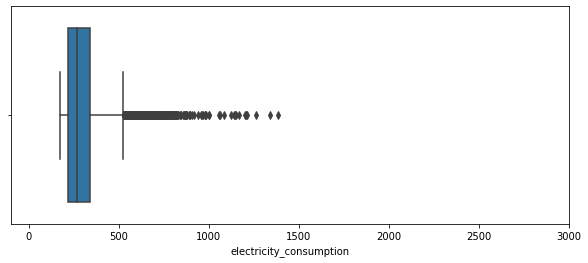

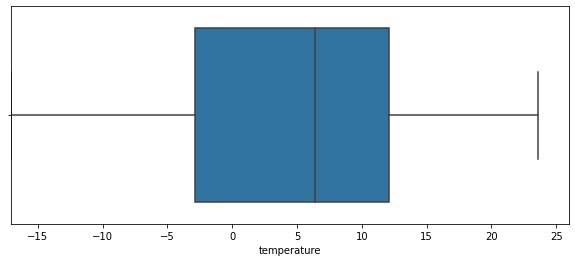

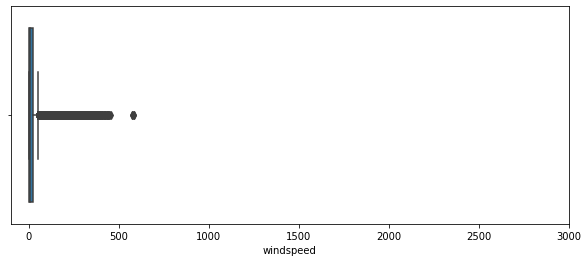

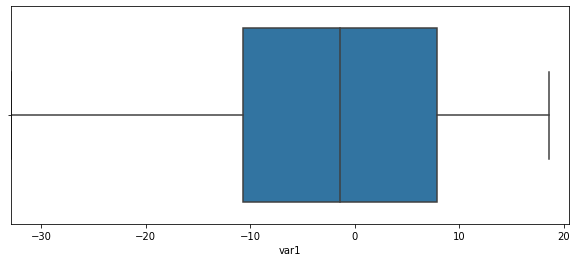

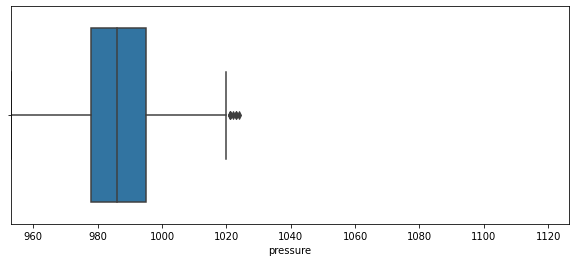

In [6]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.electricity_consumption)

plt.figure(figsize=(10,4))
plt.xlim(train.temperature.min(), train.temperature.max()*1.1)
sns.boxplot(x=train.temperature)

plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.windspeed)

plt.figure(figsize=(10,4))
plt.xlim(train.var1.min(), train.var1.max()*1.1)
sns.boxplot(x=train.var1)

plt.figure(figsize=(10,4))
plt.xlim(train.pressure.min(), train.pressure.max()*1.1)
sns.boxplot(x=train.pressure)

In [0]:
train = train[train['electricity_consumption']<=1000]

In [0]:
train = train[train['var1']>=-30]

In [0]:
train = train[train['windspeed']<=400]

-17.1
23.6
5.121189773844646


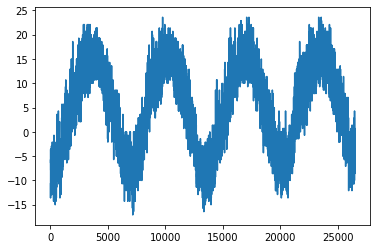

In [10]:
print(train.temperature.min())
print(train.temperature.max())
print(train.temperature.mean())
pyplot.plot(train.temperature)

953.0
1024.0
986.4262347780046


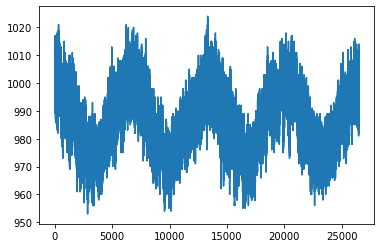

In [11]:
print(train.pressure.min())
print(train.pressure.max())
print(train.pressure.mean())
pyplot.plot(train.pressure)

1.075
399.645
23.427310339614312


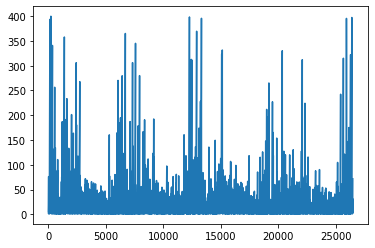

In [12]:
print(train.windspeed.min())
print(train.windspeed.max())
print(train.windspeed.mean())
pyplot.plot(train.windspeed)

-29.3
18.6
-1.8917933590500007


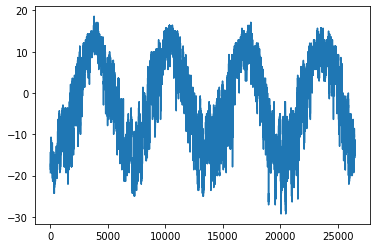

In [13]:
print(train.var1.min())
print(train.var1.max())
print(train.var1.mean())
pyplot.plot(train.var1)

In [14]:
train.var2.unique()

array(['A', 'B', 'C'], dtype=object)

In [0]:
le = LabelEncoder()
train["var2_label"] = le.fit_transform(train.var2)
train = train.drop('var2',axis=1)
le = LabelEncoder()
test["var2_label"] = le.fit_transform(test.var2)
test = test.drop('var2',axis=1)

In [16]:
train.head()

,ID,datetime,temperature,var1,pressure,windspeed,electricity_consumption,var2_label
5,5,2013-07-01 05:00:00,-10.7,-19.3,1013.0,2.790,216.0,0
6,6,2013-07-01 06:00:00,-13.6,-17.1,1006.0,4.380,219.0,0
7,7,2013-07-01 07:00:00,-11.4,-17.9,997.0,7.635,222.0,0
8,8,2013-07-01 08:00:00,-10.7,-18.6,1012.0,12.055,219.0,0
9,9,2013-07-01 09:00:00,-10.0,-16.4,1002.0,17.975,222.0,0


In [17]:
test.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2_label
0,552,2013-07-24 00:00:00,-10.0,-16.4,1011.0,263.280,0
1,553,2013-07-24 01:00:00,-10.0,-20.7,1011.0,267.175,0
2,554,2013-07-24 02:00:00,-10.7,-17.1,1003.0,269.555,0
3,555,2013-07-24 03:00:00,-13.6,-20.7,1008.0,273.060,0
4,556,2013-07-24 04:00:00,-10.7,-17.1,1006.0,1.765,0


In [0]:
train['DateAndTime'] = pd.to_datetime(train['datetime'])
test['DateAndTime'] = pd.to_datetime(test['datetime'])

train['month'] = train['DateAndTime'].dt.month
train['day'] = train['DateAndTime'].dt.day
train['year'] = train['DateAndTime'].dt.year
train['hour'] = train['DateAndTime'].dt.hour

test['month'] = test['DateAndTime'].dt.month
test['day'] = test['DateAndTime'].dt.day
test['year'] = test['DateAndTime'].dt.year
test['hour'] = test['DateAndTime'].dt.hour

In [0]:
train = train.drop('datetime',axis=1)
test = test.drop('datetime', axis=1)

In [0]:
train = train.drop('DateAndTime',axis=1)
test = test.drop('DateAndTime', axis=1)

In [0]:
train['temp_shift_1'] = train.groupby('day')['temperature'].shift(1)
train['pres_shift_1'] = train.groupby('day')['pressure'].shift(1)
train['ws_shift_1'] = train.groupby('day')['windspeed'].shift(1)
train['var1_shift_1'] = train.groupby('day')['var1'].shift(1)
train['var2_label_shift_1'] = train.groupby('day')['var2_label'].shift(1)

In [0]:
test['temp_shift_1'] = test.groupby('day')['temperature'].shift(1)
test['pres_shift_1'] = test.groupby('day')['pressure'].shift(1)
test['ws_shift_1'] = test.groupby('day')['windspeed'].shift(1)
test['var1_shift_1'] = test.groupby('day')['var1'].shift(1)
test['var2_label_shift_1'] = test.groupby('day')['var2_label'].shift(1)

In [23]:
train.isnull().sum().sum()

115

In [0]:
train = train.dropna()

In [25]:
train.isnull().sum().sum()

0

In [26]:
test.isnull().sum().sum()

40

In [0]:
test = test.fillna(test.mean())

In [28]:
test.isnull().sum().sum()

0

In [0]:
X = train.copy()

In [0]:
y = X['electricity_consumption']
X = X.drop(['electricity_consumption'],axis=1)

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=18)

***LGBM***

In [0]:
model = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              importance_type='split', learning_rate=0.025, max_depth=8,
              min_child_samples=20, min_child_weight=100, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=256,
              random_state=None, reg_alpha=0.8, reg_lamda=0.8,silent=True)

In [33]:
model.fit(X_train, y_train, eval_metric='rmse')

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              importance_type='split', learning_rate=0.025, max_depth=8,
              min_child_samples=20, min_child_weight=100, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=256, objective=None,
              random_state=None, reg_alpha=0.8, reg_lambda=0.0, reg_lamda=0.8,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

***Random Forest***

In [0]:
# model = RandomForestRegressor(n_estimators=2000,random_state=42)

In [0]:
# model.fit(X_train, y_train)

**XGBOOST**

In [0]:
#model = xgb.XGBRegressor(n_estimators=800, learning_rate=0.05,objective='reg:squarederror',max_depth=10,reg_alpha=0,reg_lambda=1,booster='gbtree')
#model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.25,objective='reg:linear',max_depth=8,reg_alpha=0.7,reg_lambda=0.7,booster='gbtree')
#model = xgb.XGBRegressor(n_estimators=2000)

In [0]:
#model.fit(X_train, y_train,verbose=True, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds = 10)
#model.fit(X_train,y_train)

In [0]:
# _ = plot_importance(model, height=0.9)

**CNN**

In [0]:
# model = Sequential()
# model.add(Reshape((1,X_train.shape[1],1)))
# model.add(Conv2D(filters = 32, kernel_size = (1,1),padding = 'Same',
#              activation ='relu', input_shape = (1,X_train.shape[1],1)))
# model.add(Conv2D(filters = 32, kernel_size = (1,1),padding = 'Same',
#              activation ='relu'))
# model.add(Conv2D(filters = 32, kernel_size = (1,1),padding = 'Same',
#              activation ='relu'))
# model.add(Flatten())
# model.add(Dense (500, activation='relu'))
# model.add(Dense (10, activation='relu'))
# model.add(Dense (1, activation='linear'))
# model.compile(loss='mean_squared_error', optimizer='adam',
#               metrics=['mse'])

In [0]:
# CNNModel = model.fit(np.array(X_train), np.array(y_train), nb_epoch=10000, batch_size=20, validation_data=(np.array(X_val),np.array(y_val)))

**LSTM**

In [0]:
# model = Sequential()
# model.add(LSTM(50, activation='relu', input_shape=(1,X_train.shape[1],1)))
# model.add(Dense (10, activation='relu'))
# model.add(Dense (1, activation='linear'))
# model.compile(loss='mean_squared_error', optimizer='adam',
#               metrics=['mse'])
# model.summary()

**Submission**

In [0]:
predict_val = model.predict(X_val)

In [43]:
np.sqrt(mean_squared_error(y_val, predict_val))

56.75567437064014

In [0]:
predictions = model.predict(test)
submit = sample_submission.copy()
submit['electricity_consumption'] = predictions
submit.to_csv("submission_LGBM.csv",index=False)

**Drop Features**

In [0]:
# train = train.drop(['month_var1_avg','day_var1_avg'],axis=1)
# test = test.drop(['month_var1_avg','day_var1_avg'],axis=1)

In [0]:
# train = train.drop(['temp_pres_diff', 'ws_pres_diff', 'temp_ws_diff', 'temp_roll_24_mean',
#        'pres_roll_24_mean', 'ws_roll_24_mean', 'vo_roll_24_mean'],axis=1)

In [0]:
# test = test.drop(['temp_pres_diff', 'ws_pres_diff', 'temp_ws_diff', 'temp_roll_24_mean',
#        'pres_roll_24_mean', 'ws_roll_24_mean', 'vo_roll_24_mean'],axis=1)

In [0]:
# train = train.drop(['pressure','var2_label'],axis=1)
# test = test.drop(['pressure','var2_label'],axis=1)

**Unused Features**

In [0]:
# train['temp_shift_1'] = train.groupby('day')['temperature'].shift(2)
# train['pres_shift_1'] = train.groupby('day')['pressure'].shift(2)
# train['ws_shift_1'] = train.groupby('day')['windspeed'].shift(2)
# train['var1_shift_1'] = train.groupby('day')['var1'].shift(2)
# train['var2_label_shift_1'] = train.groupby('day')['var2_label'].shift(2)

In [0]:
# test['temp_shift_1'] = test.groupby('day')['temperature'].shift(2)
# test['pres_shift_1'] = test.groupby('day')['pressure'].shift(2)
# test['ws_shift_1'] = test.groupby('day')['windspeed'].shift(2)
# test['var1_shift_1'] = test.groupby('day')['var1'].shift(2)
# test['var2_label_shift_1'] = test.groupby('day')['var2_label'].shift(2)

In [0]:
# train['temp_pres_diff'] = train['temperature']-train['pressure']
# train['ws_pres_diff'] = train['windspeed']-train['pressure']
# train['temp_ws_diff'] = train['windspeed']-train['temperature']

# test['temp_pres_diff'] = test['temperature']-test['pressure']
# test['ws_pres_diff'] = test['windspeed']-test['pressure']
# test['temp_ws_diff'] = test['windspeed']-test['temperature']

In [0]:
# temperatures = train['temperature']
# window = temperatures.rolling(window=24)
# std = window.std()
# train['temp_roll_24_mean']=std

# temperatures = test['temperature']
# window = temperatures.rolling(window=24)
# std = window.std()
# test['temp_roll_24_mean']=std

In [0]:
# pressures = train['pressure']
# window = pressures.rolling(window=24)
# std = window.std()
# train['pres_roll_24_mean']=std

# pressures = test['pressure']
# window = pressures.rolling(window=24)
# std = window.std()
# test['pres_roll_24_mean']=std

In [0]:
# windspeeds = train['windspeed']
# window = windspeeds.rolling(window=24)
# std = window.std()
# train['ws_roll_24_mean']=std

# windspeeds = test['windspeed']
# window = windspeeds.rolling(window=24)
# std = window.std()
# test['ws_roll_24_mean']=std

In [0]:
# varones = train['var1']
# window = varones.rolling(window=24)
# std = window.std()
# train['vo_roll_24_mean']=std

# varones = test['var1']
# window = varones.rolling(window=24)
# std = window.std()
# test['vo_roll_24_mean']=std

In [0]:
# group = train.groupby(['month']).agg({'temperature':['mean']})
# group.columns=['month_temp_avg']
# group.reset_index(inplace=True)
# train = train.merge(group,how='left',on='month')

# group = train.groupby(['day']).agg({'temperature':['mean']})
# group.columns=['day_temp_avg']
# group.reset_index(inplace=True)
# train = train.merge(group,how='left',on='day')

In [0]:
# group = test.groupby(['month']).agg({'temperature':['mean']})
# group.columns=['month_temp_avg']
# group.reset_index(inplace=True)
# test = test.merge(group,how='left',on='month')

# group = test.groupby(['day']).agg({'temperature':['mean']})
# group.columns=['day_temp_avg']
# group.reset_index(inplace=True)
# test = test.merge(group,how='left',on='day')

In [0]:
# group = train.groupby(['month']).agg({'windspeed':['mean']})
# group.columns=['month_ws_avg']
# group.reset_index(inplace=True)
# train = train.merge(group,how='left',on='month')

# group = train.groupby(['day']).agg({'windspeed':['mean']})
# group.columns=['day_ws_avg']
# group.reset_index(inplace=True)
# train = train.merge(group,how='left',on='day')

In [0]:
# group = test.groupby(['month']).agg({'windspeed':['mean']})
# group.columns=['month_ws_avg']
# group.reset_index(inplace=True)
# test = test.merge(group,how='left',on='month')

# group = test.groupby(['day']).agg({'windspeed':['mean']})
# group.columns=['day_ws_avg']
# group.reset_index(inplace=True)
# test = test.merge(group,how='left',on='day')

In [0]:
# group = train.groupby(['month']).agg({'pressure':['mean']})
# group.columns=['month_pressure_avg']
# group.reset_index(inplace=True)
# train = train.merge(group,how='left',on='month')

# group = train.groupby(['day']).agg({'pressure':['mean']})
# group.columns=['day_pressure_avg']
# group.reset_index(inplace=True)
# train = train.merge(group,how='left',on='day')

In [0]:
# group = test.groupby(['month']).agg({'pressure':['mean']})
# group.columns=['month_pressure_avg']
# group.reset_index(inplace=True)
# test = test.merge(group,how='left',on='month')

# group = test.groupby(['day']).agg({'pressure':['mean']})
# group.columns=['day_pressure_avg']
# group.reset_index(inplace=True)
# test = test.merge(group,how='left',on='day')

In [0]:
# group = train.groupby(['month']).agg({'var1':['mean']})
# group.columns=['month_var1_avg']
# group.reset_index(inplace=True)
# train = train.merge(group,how='left',on='month')

# group = train.groupby(['day']).agg({'var1':['mean']})
# group.columns=['day_var1_avg']
# group.reset_index(inplace=True)
# train = train.merge(group,how='left',on='day')

In [0]:
# group = test.groupby(['month']).agg({'var1':['mean']})
# group.columns=['month_var1_avg']
# group.reset_index(inplace=True)
# test = test.merge(group,how='left',on='month')

# group = test.groupby(['day']).agg({'var1':['mean']})
# group.columns=['day_var1_avg']
# group.reset_index(inplace=True)
# test = test.merge(group,how='left',on='day')